## SNR Calculations
We are trying to conclusively prove that the residual signals from 2d vs 3d fits are detectable. Mostly the issue is with limb darkening... since there is a tendency of the network to fit a higher order limb darkening parameter to the fit.

But lets see.

In [1]:
#importing directories
from random import gauss
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
from astropy.io import ascii
#from ellc import lc
from transit import occultnonlin, occultquad

In [5]:
def gausses(x, A1, m1, s1, A2, m2, s2):
    y = A1*np.exp(-(x-m1)**2/(2*s1**2)) + A2*np.exp(-(x-m2)**2/(2*s2**2))
    return(y)

def lorz(x,A1,x0,g, A2, x02, g2):
    y = A1 / (1*((x-x0)**2+(g/2)**2)) + A2 / (1*((x-x02)**2+(g2/2)**2))
    return(y)

def new_plar(ph,p,minus, plus,rorb):
    u1 = (plus + minus)/2
    u2 = (plus - minus)/2
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free(ph,p,u1,plus,rorb):
    u2 = plus - u1
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free2(ph,p,u1,u2,rorb):
    znp = np.sqrt(np.abs(rorb*np.sin(ph*np.pi))**2)
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_v2(ph,p,u1,u2,rorb, imp):
    incl = np.arccos(imp/rorb)*180/np.pi
    a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='quad',ldc_1=[u1,u2],
        shape_1='sphere', shape_2='sphere')
    return(a -1) 

def smooth(arr,k=10):
    kernel = np.ones(k)/k
    v=np.convolve(arr, kernel, mode='same')
    return(v)


We are measuring the parameter value with increasing noise... we also need to factor in a variance parameter... so lets 
do that

In [3]:
#d2 d3 std2 std3
df = pd.read_csv('../../plots/hpc_stash/2d3d_0.2R_circ_corr.csv', delimiter=',')
np.random.seed(10000)

std_n = np.logspace(-1, -5, 20)
d2=np.array(df['2d'])-1
d3=np.array(df['3d'])-1
ph = np.array(df['frame'])*0.5/ np.pi
std2 = np.array(df['2dstd'])
std3 = np.array(df['3dstd'])

parrarr2d=[]
parrarr3d=[]
stdarr2d=[]
stdarr3d=[]
snrarr2=[]
snrarr3=[]

for el in std_n:
    sumpar3d=[]
    sumpar2d=[]
    for i in range(20):
        np.random.seed(10000*i)
        noise = np.random.normal(1,el,len(df))
        d2n = (np.array(df['2d'])*noise-1)
        d3n = (np.array(df['3d'])*noise-1)
        
        par2d, cov2d=curve_fit(new_plar_v2, ph, d2n, bounds=([0,0,0,2,0], [1,1,1,10,1]))
        par3d, cov3d=curve_fit(new_plar_v2, ph, d3n, bounds=([0,0,0,2,0], [1,1,1,10,1]))
        #print(np.round(par3d,2))
        sumpar2d.append(par2d)
        sumpar3d.append(par3d)
    parrarr2d.append(np.mean(np.array(sumpar2d), axis=0))
    parrarr3d.append(np.mean(np.array(sumpar3d), axis=0))
    stdarr2d.append(np.std(np.array(sumpar2d), axis=0))
    stdarr3d.append(np.std(np.array(sumpar3d), axis=0))
    

parrarr2d = np.asarray(parrarr2d)
parrarr3d = np.asarray(parrarr3d)
stdarr2d = np.asarray(stdarr2d)
stdarr3d = np.asarray(stdarr3d)




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


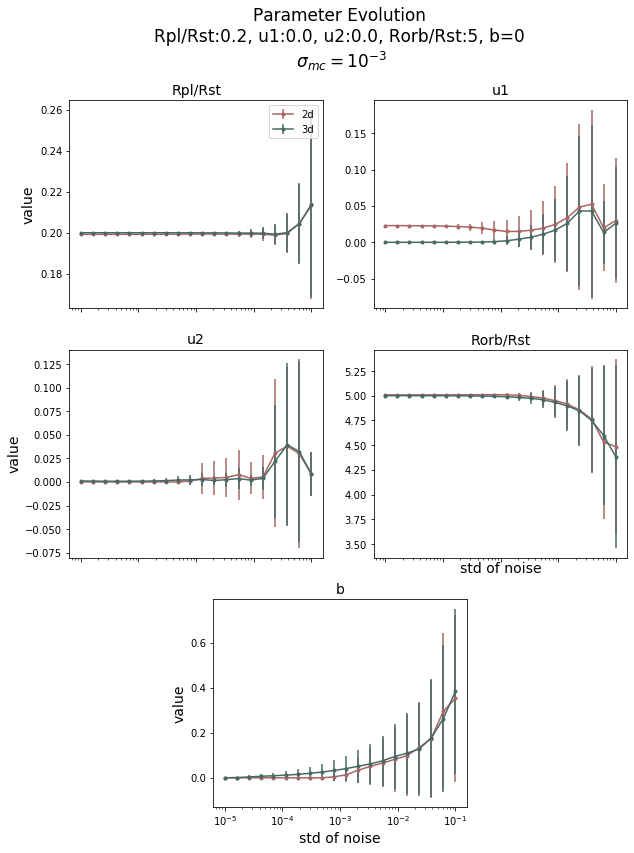

In [11]:
fig, ax = plt.subplots(3,2,figsize=(10,13), sharex=True)
c1="#a86464"
c2="#466964"
plt.suptitle('Parameter Evolution\nRpl/Rst:0.2, u1:0.0, u2:0.0, Rorb/Rst:5, b=0\n $\sigma_{mc} = 10^{-3}$', size=17)
ax[0][0].errorbar(std_n,parrarr2d[:,0],stdarr2d[:,0],None, marker='.', label='2d', color=c1)
ax[0][0].errorbar(std_n,parrarr3d[:,0],stdarr3d[:,0],None, marker='.', label='3d', color=c2)
ax[0][0].set_title('Rpl/Rst', size=14)
ax[0][0].set_xscale('log')
ax[0][0].legend()
ax[0][1].errorbar(std_n,parrarr2d[:,1],stdarr2d[:,1],None, marker='.', color=c1)
ax[0][1].errorbar(std_n,parrarr3d[:,1],stdarr3d[:,1],None, marker='.', color=c2)
ax[0][1].set_title('u1', size=14)
ax[0][1].set_xscale('log')
ax[1][0].errorbar(std_n,parrarr2d[:,2],stdarr2d[:,2],None, marker='.', color=c1)
ax[1][0].errorbar(std_n,parrarr3d[:,2],stdarr3d[:,2],None, marker='.', color=c2)
ax[1][0].set_title('u2', size=14)
ax[1][0].set_xscale('log')
ax[1][1].errorbar(std_n,parrarr2d[:,3],stdarr2d[:,3],None, marker='.', color=c1)
ax[1][1].errorbar(std_n,parrarr3d[:,3],stdarr3d[:,3],None, marker='.', color=c2)
ax[1][1].set_title('Rorb/Rst', size=14)
ax[1][1].set_xscale('log')
ax[2][0].errorbar(std_n,parrarr2d[:,4],stdarr2d[:,4],None, marker='.', color=c1)
ax[2][0].errorbar(std_n,parrarr3d[:,4],stdarr3d[:,4],None, marker='.', color=c2)
ax[2][0].set_title('b', size=14)
ax[2][0].set_xscale('log')
ax[2][0].set_xlabel('std of noise', size=14)
ax[1][1].set_xlabel('std of noise', size=14)
ax[0][0].set_ylabel('value', size=14)
ax[1][0].set_ylabel('value', size=14)
ax[2][0].set_ylabel('value', size=14)
ax[2][1].set_visible(False)
box = ax[2][0].get_position()
box.x0 = box.x0 + 0.2
box.x1 = box.x1 + 0.2
ax[2][0].set_position(box)
plt.savefig('snr_calc.eps')
plt.show()

That was for the parameter estimation... now we need to see how bad it must get before we can't see residuals

0.00037599057034287323


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


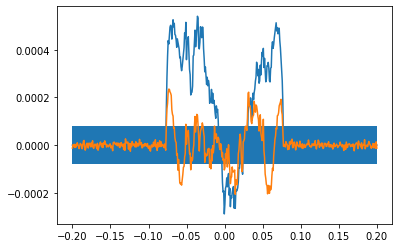

In [5]:
df = pd.read_csv('../../plots/hpc_stash/2d3d_0.2R_circ_corr.csv', delimiter=',')
np.random.seed(10000)

std_n = np.logspace(-1, -5, 20)
noise = np.random.normal(1,0.00001,len(df))
d2=np.array(df['2d'])*noise-1
d3=np.array(df['3d'])*noise-1
ph = np.array(df['frame'])/ np.pi
std2 = np.array(df['2dstd'])
std3 = np.array(df['3dstd'])
print(np.mean(std2))

ideal = new_plar_free2(ph, 0.2, 0,0,5)

plt.plot(ph,d2-d3)
par2d, cov2d=curve_fit(new_plar_free2, ph, d2, bounds=([0,0,0,1], [1,1,1,10]))
plt.fill_between(ph, -0.0000794*np.ones(len(ph)), 0.0000794*np.ones(len(ph)))
plt.plot(ph,d2-new_plar_free2(ph, *par2d))


7.990770214140859e-05


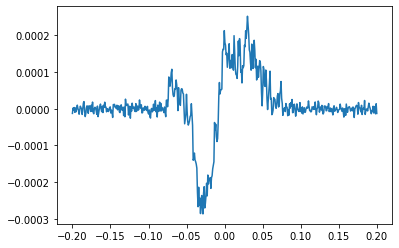

In [6]:
#plt.errorbar(ph, d3, std3, None, zorder=1)
plt.plot(ph, d3-ideal, zorder=2)
print(np.std(d3-ideal))
#plt.errorbar(ph, d3, std3, None)
#plt.xlim(-0.01,0.01)
plt.show()

In [39]:
#here's the plan... get 3d and 2d, add noise , compare 3d to 3d to get net noise, monte carlo + added random noise.
#Then fit the same noise to 2d, detect a parameter set, get residuals... check out the nsigma of the residual peak.
#one more graph where we do not try to fit the 3d model, but simply take residual from ideal 3d case. plot graph between
#nsigma peak and std of noise for both cases


def get_graph_for_radius(filepath, res, lim1, lim2,rpl, rorb):
    samp_mod=[]
    samp_tr=[]
    samp_sig=[]
    df = pd.read_csv(filepath, delimiter=',')
    np.random.seed(10000)
    std_n = np.logspace(lim1, lim2, res)
    ph = np.array(df['frame'])/ np.pi
    ideal = new_plar_free2(ph, rpl, 0,0,rorb)
    print(np.abs(min(ideal)/np.std(np.array(df['3d']) - ideal)))
    x= []
    y=[]
    xstd=[]
    ystd=[]
    pararr=[]

    for el in std_n:
        tempx=[]
        tempy=[]
        temppar=[]
        for i in range(20):
            np.random.seed(10000*i)
            noise = np.random.normal(1,el,len(df))
            d2n=np.array(df['2d'])*noise-1
            np.random.shuffle(noise)
            d3n=np.array(df['3d'])*noise-1
            sig = np.std(d3n - ideal)  
            tempx.append(np.abs(min(ideal))/sig)
            try: par2d, cov2d=curve_fit(new_plar_free2, ph, d2n, bounds=([rpl*0.5,0,0,rorb*0.5], [rpl*1.5,0.2,0.2,rorb*1.5]))
            except: continue
            res = d2n - new_plar_free2(ph,*par2d)
            peak = np.max(np.convolve(res,np.ones(2)/2, mode='same'))
            temppar.append(par2d)

            if(i==0):
                samp_mod.append(d2n)
                samp_tr.append(new_plar_free2(ph,*par2d))
                samp_sig.append(sig)
            # plt.plot(ph,d2n)
            # plt.plot(ph,new_plar_free2(ph,*par2d))
            # plt.plot(ph,np.convolve(res,np.ones(5)/5, mode='same'))
            # plt.fill_between(ph, -sig*np.ones(len(ph)),sig*np.ones(len(ph)), alpha=0.2)
            # plt.show()
            detect = peak/sig
            tempy.append(detect)
        x.append(np.mean(tempx, axis=0))
        y.append(np.mean(tempy, axis=0))
        pararr.append(np.mean(temppar, axis=0))
        xstd.append(np.std(tempx, axis=0))
        ystd.append(np.std(tempy, axis=0))
        
    return(x,y,xstd,ystd, pararr, ph, samp_tr, samp_mod, samp_sig)
    

#print(np.mean(std2))



503.2949204112337
188.0983659792743
472.42188019519017
10


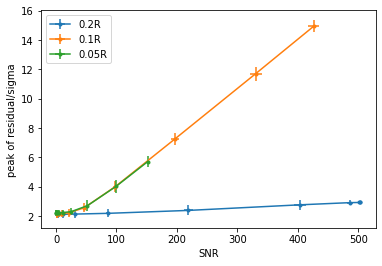

In [40]:
x1,y1,x1std,y1std, p1, ph,strn, smod, ssig=get_graph_for_radius('../../plots/hpc_stash/2d3d_0.2R_circ_corr.csv',10,-2,-6,0.2,5)
x3,y3,x3std,y3std, p3, ph,strn, smod, ssig=get_graph_for_radius('../../plots/hpc_stash/2d3d_0.05R_circ.csv',10,-2,-5,0.05,2)
x2,y2,x2std, y2std, p2, ph,strn, smod, ssig=get_graph_for_radius('../../plots/hpc_stash/2d3d_0.1R_circ.csv',10,-2,-5,0.1,2)

print(len(x1))
plt.errorbar(x1,y1,y1std, x1std, marker='.', label='0.2R')
plt.errorbar(x2,y2,y2std, x2std, marker='.', label='0.1R')
plt.errorbar(x3,y3,y3std, x3std, marker='.', label='0.05R')
plt.xlabel('SNR')
plt.ylabel('peak of residual/sigma')
#plt.plot(x3,y3, marker='.', label='0.01R')
plt.legend()
#[print(p1[i],p2[i]) for i in range(4)]
#plt.xscale('log')
plt.savefig('snr_detect.png')
plt.show()
# dfop = pd.DataFrame(zip(x1,y1,x1std,y1std,x2,y2,x2std,y2std,x3,y3,x3std,y3std),
#     columns=['0.2snr','0.2peak','0.2snrvar','0.2pkvar','0.1snr','0.1peak','0.1snrvar','0.1pkvar','0.05snr','0.05peak','0.05snrvar','0.05pkvar'])

# dfop.to_csv('fprez_snrplot.csv', sep=',',index=False)

In [41]:
print(len(strn),len(smod))
# for i in range(3,10):
#     plt.fill_between(ph, -ssig[i]*np.ones(len(ph)),ssig[i]*np.ones(len(ph)), alpha=0.2)
#     plt.plot(ph,np.convolve(str[i],np.ones(5)/5,mode='same')-smod[i])
#     #plt.plot(ph,str[i])
#     #plt.plot(ph,smod[i])
#     #plt.show()

net=[]
net.append(ph)
col=['phase']
#net.append(ssig)
for i in range(10):
    print(ssig[i])
    col.append('tr'+str(np.round(-min(smod[i])/ssig[i],2)))
    col.append('mod'+str(np.round(-min(smod[i])/ssig[i],2)))
    col.append('res'+str(np.round(-min(smod[i])/ssig[i],2)))
    net.append(strn[i])
    net.append(smod[i])
    net.append(np.convolve(strn[i]-smod[i],np.ones(5)/5,mode='same'))

print(np.array(net).shape)
print(len(col))

dfop = pd.DataFrame(np.transpose(np.array(net)),columns=col)
dfop.to_csv('fprez_noiselist.csv', sep=',',index=False)
#for i in range()


10 10
0.009934296777083587
0.004611416666590476
0.0021407985367690734
0.000994133827176623
0.00046210273387189065
0.00021559156305916212
0.00010208917578053067
5.121859358150005e-05
3.047910795099806e-05
2.3608576462847846e-05
(31, 500)
31
